# Experiments

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *
from train import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)

np.random.seed(seed)

try:
    if torch.backend.mpas.is_available():
        device = torch.device('mps')
except:
    torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
import torch
import torch.distributions as dist

tensor([4., 0.])


In [134]:
alphas=torch.Tensor([2,2])
betas=torch.Tensor([10,11])

def gen_multiple_spike_train_counts(alpha, beta, time_steps=50):
    
    n_trains = alpha.shape
    flag = False
    
    while not flag:
        ts = dist.Gamma(concentration=alpha, rate=beta).sample(sample_shape=torch.Size([500]))
        cumu_time = torch.cumsum(ts, dim=0)

            bin_counts = torch.vstack([torch.bincount(cumu_time[:,i].long())[:time_steps] for i in tqdm(range(n_trains))])
            
            flag = True

            flag = False

    return bin_counts

In [135]:
from tqdm import tqdm
def generate_time_dependent_stochastic_pattern(BNN, input_dim, n_data_points, alphas, betas, time_steps=50, gaussian_noise=False):
    X = torch.stack([gen_multiple_spike_train_counts(alpha=alphas, beta=betas, time_steps=time_steps) for _ in tqdm(range( n_data_points))])

generate_time_dependent_stochastic_pattern(None, None, 10000, alphas, betas)






  0%|          | 0/10000 [00:00<?, ?it/s]

excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
e

KeyboardInterrupt: 

## Approximate BNNs
### Feedforward BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_ff_train_256_0t)
X_test, Y_test = load_data('./data/', 'abnn_ff_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_ff_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6700641810894012, time elapsed: 0 h 2 m 56 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6808474659919739, time elapsed: 0 h 5 m 44 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6812590062618256, time elapsed: 0 h 8 m 31 s
4th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6446159034967422, time elapsed: 0 h 11 m 19 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6668617129325867, time elapsed: 0 h 14 m 7 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.7260499596595764, time elapsed: 0 h 16 m 52 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.6661280393600464, time elapsed: 0 h 19 m 38 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.6908062398433685, time elapsed: 0 h 22 m 19 s
9th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.661928

Best hidden unit: 256, best layers: 3


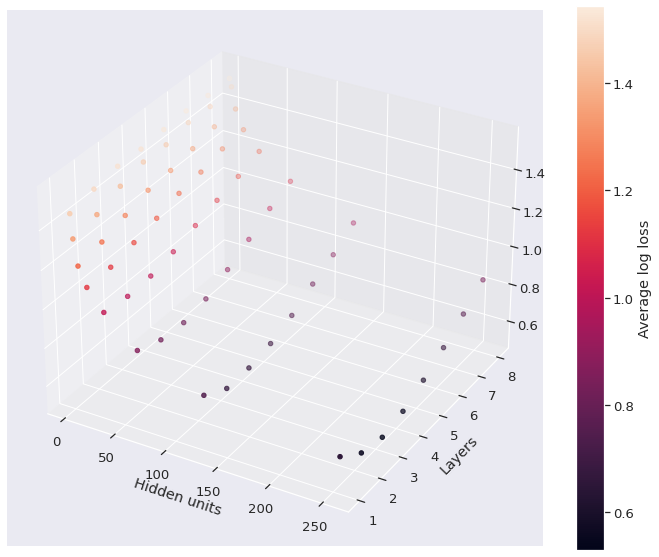

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_log_ff')

####  2. Learning with best parameter

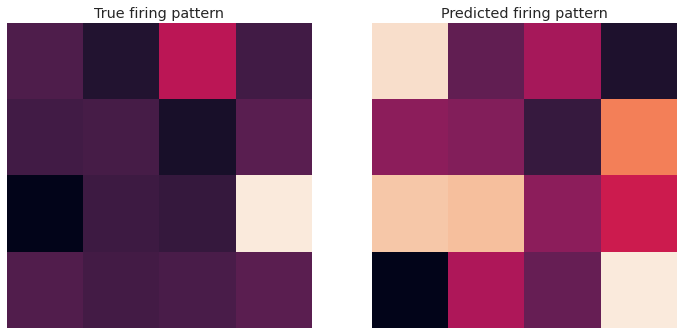

Initial eval loss: 4.6933910846710205
Epoch 1: training loss 36.971997767686844, eval loss 3.1242674589157104. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 29.11742076277733, eval loss 2.7155623137950897. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.97406142950058, eval loss 2.446341872215271. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.720835000276566, eval loss 2.26437771320343. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 21.755600959062576, eval loss 2.0886777341365814. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 20.386455833911896, eval loss 1.9807746708393097. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 19.108930602669716, eval loss 1.875606507062912. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 17.861584693193436, eval loss 1.8012462556362152. Time elapsed: 0 h 0 m 1 s.
Epoch 9: training loss 16.8479984998703, eval loss 1.7853142023086548. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training loss 16.174857407808304, eval loss 1.74046452343463

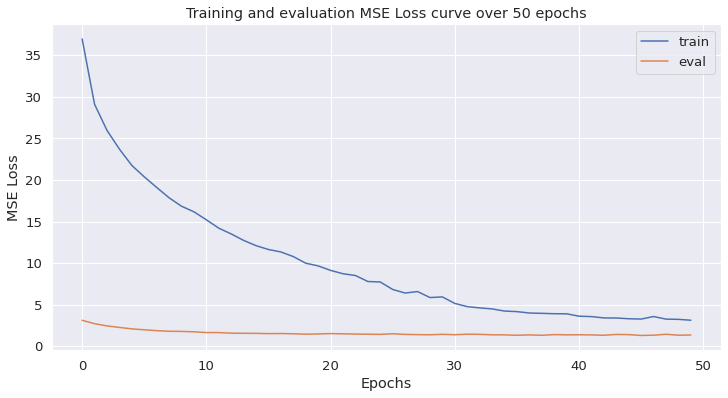

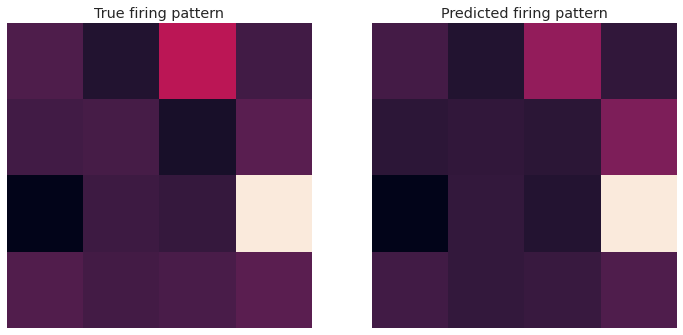

In [5]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

#### 3. Testing against predicting the mean

In [6]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.2707, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9366, device='cuda:0')


/tmp/ipykernel_12236/4047130697.py:5: UserWarning: Using a target size (torch.Size([1000, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Residual BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_resid_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_resid_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_resid_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.3419833183288574, time elapsed: 0 h 2 m 15 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.3247351050376892, time elapsed: 0 h 4 m 37 s
3th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.31125959753990173, time elapsed: 0 h 7 m 0 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.28119367361068726, time elapsed: 0 h 9 m 23 s
5th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.31096720695495605, time elapsed: 0 h 11 m 47 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.30913951992988586, time elapsed: 0 h 14 m 9 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.3124375641345978, time elapsed: 0 h 16 m 32 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.33619803190231323, time elapsed: 0 h 18 m 55 s
9th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.305

Best hidden unit: 256, best layers: 3


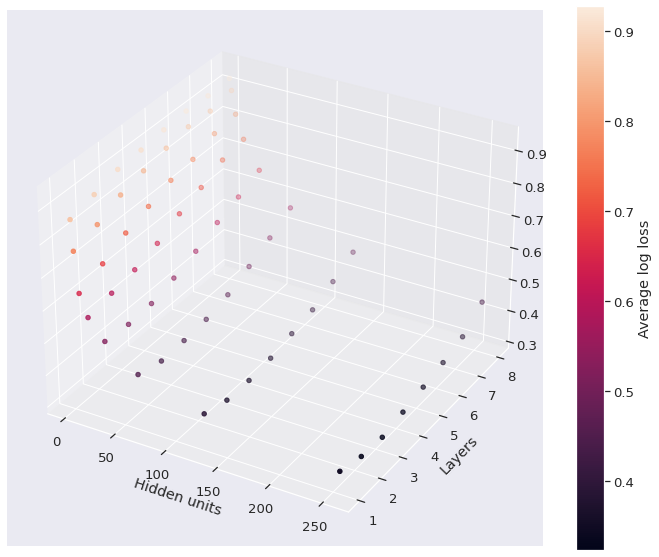

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_resid')

#### 2. Learning with best parameter

In [8]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

ValueError: Reshape dimension mismatch

#### 3. Testing against predicting the mean

In [11]:
with torch.no_grad():
    pred_mean = DNN(X_train)
    
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.2790, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.9281, device='cuda:0')


/tmp/ipykernel_12236/4047130697.py:5: UserWarning: Using a target size (torch.Size([100, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0), Y_test))


### Recurrent BNN

In [2]:
X_train, Y_train = load_data('./data/', 'abnn_cplx_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_cplx_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_cplx_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([500000, 16])


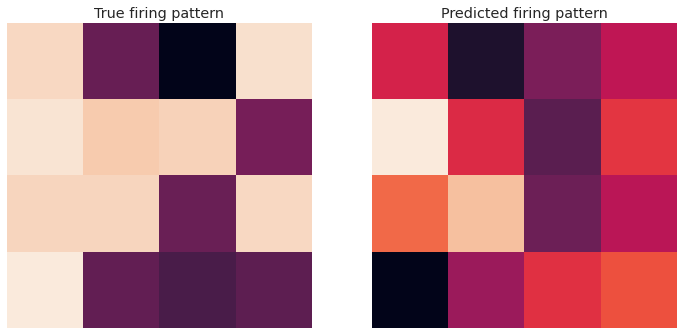

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Initial eval loss: 5.007174551486969
Epoch 1: training loss 31.45498490333557, eval loss 2.0694495141506195. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 13.462657198309898, eval loss 1.2125870734453201. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 9.798559740185738, eval loss 1.0429518669843674. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 8.732802614569664, eval loss 0.9405597597360611. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 7.928389668464661, eval loss 0.8849264085292816. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 7.348980709910393, eval loss 0.8235469907522202. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 6.869560942053795, eval loss 0.7868248075246811. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 6.513261549174786, eval loss 0.7509307265281677. Time elapsed: 0 h 0 m 1 s.
Epoch 9: training loss 6.224606573581696, eval loss 0.7324195504188538. Time elapsed: 0 h 0 m 1 s.
Epoch 10: training los

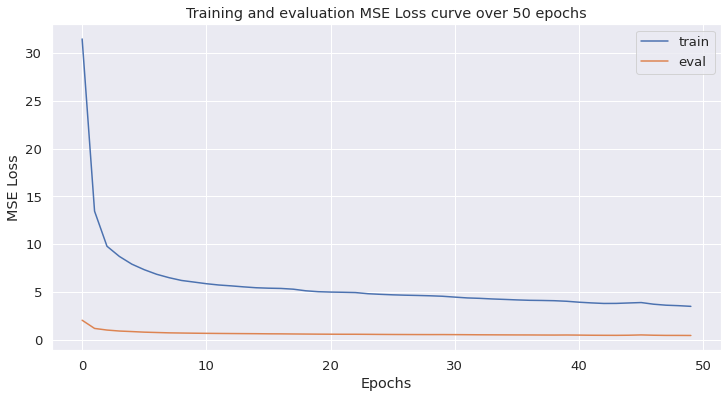

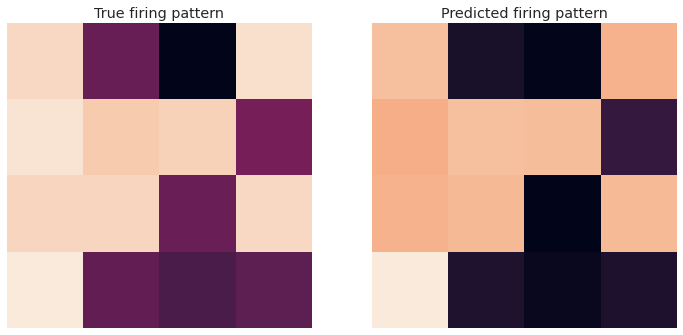

In [4]:
_X_train = X_train.view(-1, 16)
_Y_train = Y_train.view(-1, 16)
_X_test = X_test.view(-1, 16)
_Y_test = Y_test.view(-1, 16)

print(_X_train.shape)

_train_dataset = BNN_Dataset(_X_train, _Y_train)
_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

_test_dataset = BNN_Dataset(_X_test, _Y_test)
_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()
visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=_train_dataloader, test_loader=_test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(_Y_test[v_idx,:], DNN(_X_test[v_idx,:])) # visualise after training

In [ ]:
print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(_X_test), _Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(_Y_test, dim=0).repeat([50000,1]), _Y_test))

#### 1. Parameter grid search: number of layers vs number of hidden units

In [3]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

1th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.3748337924480438, time elapsed: 0 h 3 m 5 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.3825750052928925, time elapsed: 0 h 6 m 26 s
3th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.3809826076030731, time elapsed: 0 h 9 m 52 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.3844006955623627, time elapsed: 0 h 13 m 21 s
5th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.3805657923221588, time elapsed: 0 h 16 m 49 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.382154405117035, time elapsed: 0 h 20 m 17 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.3811891078948975, time elapsed: 0 h 23 m 43 s
8th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.3844658732414246, time elapsed: 0 h 27 m 12 s
9th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.3815234

Best hidden unit: 256, best layers: 6


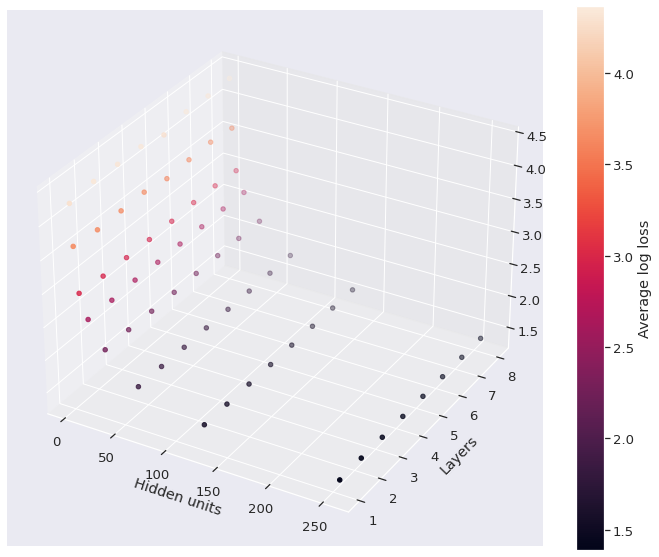

In [4]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average log loss', fname='param_search_recur')

#### 2. Learning with best parameter

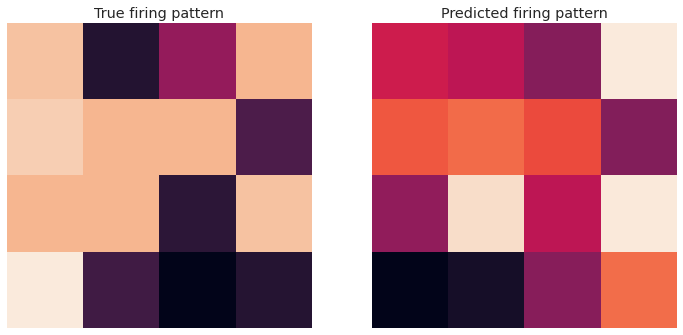

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Initial eval loss: 5.178975462913513
Epoch 1: training loss 42.48748725652695, eval loss 3.361266016960144. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 29.400306820869446, eval loss 2.726189970970154. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 25.77839833498001, eval loss 2.486097127199173. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 23.173230588436127, eval loss 2.2464558482170105. Time elapsed: 0 h 0 m 1 s.
Epoch 5: training loss 20.74292305111885, eval loss 2.0379703640937805. Time elapsed: 0 h 0 m 1 s.
Epoch 6: training loss 18.697444558143616, eval loss 1.865140050649643. Time elapsed: 0 h 0 m 1 s.
Epoch 7: training loss 17.060706168413162, eval loss 1.7275137603282928. Time elapsed: 0 h 0 m 1 s.
Epoch 8: training loss 15.807940274477005, eval loss 1.622119963169098. Time elapsed: 0 h 0 m 2 s.
Epoch 9: training loss 14.891735136508942, eval loss 1.5438739955425262. Time elapsed: 0 h 0 m 2 s.
Epoch 10: training los

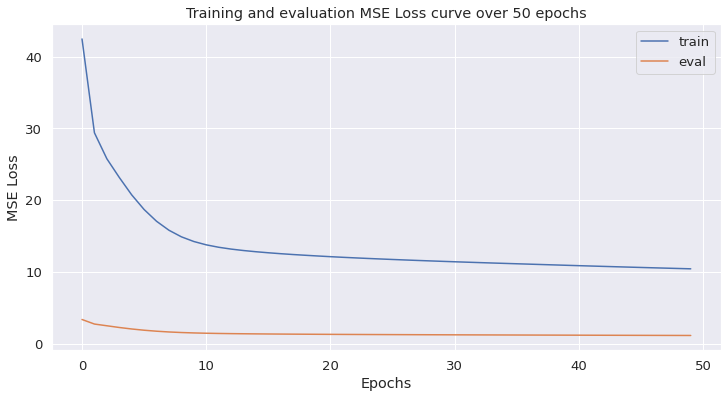

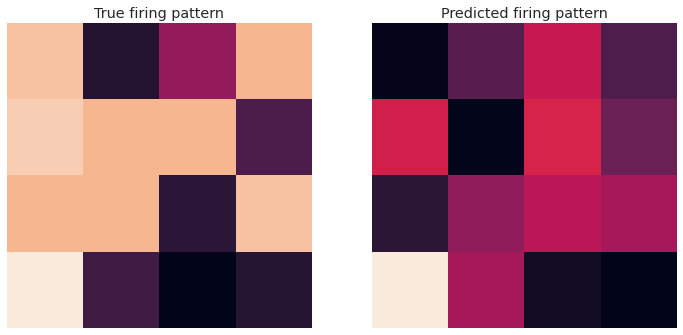

In [3]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=6, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0,:], Y_hats[v_idx,0,:])

In [ ]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

In [ ]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))

### Complex BNN

In [ ]:
X_train, Y_train = load_data('./data/', 'abnn_cplx_train_256_0.5_4_0.5.pkl')
X_test, Y_test = load_data('./data/', 'abnn_cplx_test_256_0.5_4_0.5.pkl')
X_valid, Y_valid = load_data('./data/', 'abnn_cplx_valid_256_0.5_4_0.5.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Parameter grid search: number of layers vs number of hidden units

#### 2. Learning with best parameter

## BVC Simulation

In [1]:
from utils import plot_bvc_firing_field
from bvc import BVC, RectangleEnvironment
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import ReLU
import torch

In [2]:
l = 80
w = 80
env = RectangleEnvironment(l, w)
bvc1 = BVC(50, 0 * torch.pi)
bvc2 = BVC(50, 1/2*torch.pi)
# plot_bvc_firing_field(bvc1)

In [3]:
n = 100
x, y = torch.meshgrid(torch.linspace(0, l, n), torch.linspace(0, w, n))
distances, bearings, angles = env.compute_wall_dist((x,y))

fr1 = bvc1.obtain_net_firing_rate(distances, bearings, angles)
fr2 = bvc2.obtain_net_firing_rate(distances, bearings, angles)

/home/daniel/.local/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


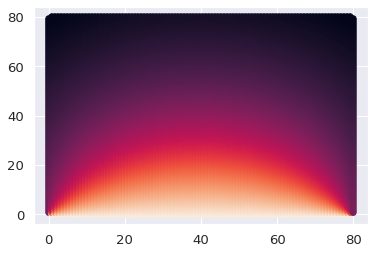

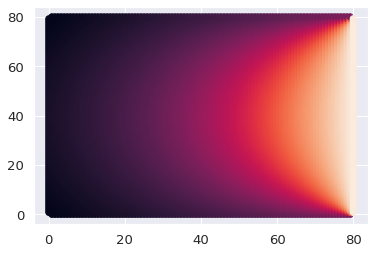

In [4]:
plt.figure()
plt.scatter(x,y, c=fr1)
plt.figure()
plt.scatter(x,y, c=fr2)

/tmp/ipykernel_49039/3979716120.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


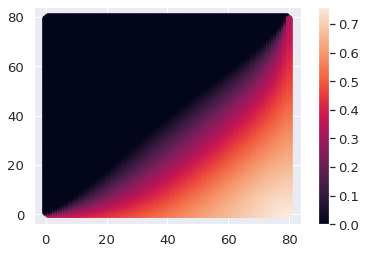

In [5]:
A = 100
Phi = ReLU()
T = 0.02

pcfr = A * Phi(fr1 + fr2 - T)
plt.scatter(x, y, c=pcfr)
plt.colorbar()